# END-TO-END IMPACT CALCULATION

## Goal of this tutorial

The goal of this tutorial is to show a full end-to-end impact computation. Note that this tutorial exemplifies the work flow, but does not explore all possible features.

## What is an Impact?

The impact is the combined effect of hazard events on a set of exposures mediated by a set of impact functions. By computing the impact for each event (historical and synthetic) and for each exposure value at each geographical location, the Impact class provides different risk measures, such as the expected annual impact per exposure, the probable maximum impact for different return periods, and the total average annual impact.

## Impact class data structure

The impact class does not require any attributes to be defined by the user. All attributes are set by the method `ImpactCalc.impact()`. This method requires three attributes: an `Exposure`, a `Hazard`, and an `ImpactFuncSet`. After calling `ImpactCalc(Exposure, ImpactFuncSet, Hazard).impact(save_mat=False)`, the Impact object has the following attributes:

| Attributes from input | Data Type | Description|
| :- | :- | :- |
| event_id |list(int)| id (>0) of each hazard event (Hazard.event_id)|
| event_name |(list(str))| name of each event (Hazard.event_name)|
| date |np.array| date of events (Hazard.date)|
| coord_exp |np.array| exposures coordinates [lat, lon] (in degrees) (Exposure.latidue, Exposure.longitude)|
| frequency |np.array| frequency of events (Hazard.frequency)|
| frequency_unit |str| unit of event frequency, by default '1/year', i.e., annual (Hazard.frequency_unit)|
| unit |str| value unit used (Exposure.value_unit)|
| csr |str| unit system for Exposure and Hazard geographical data (Exposure.csr)|

<br>
<br>

| Computed attributes | Data Type | Description|
| :- | :- | :- |
| at_event |np.array| impact for each hazard event summed over all locations |
| eai_exp |np.array| expected annual impact for each locations, summed over all events weigthed by frequency |
| aai_agg |float| total annual average aggregated impact value (summed over events and locations) |
| impt_mat |sparse.csr_matrix| This is the impact matrix. This matrix has the events as rows and the exposure points as columns (num_events X num_exp). It will only be filled with impact values if save_mat is True. |
| tot_value |float| total exposure value affected (sum of value all exposures locations affected by at least one hazard event) |

All other methods compute values from the attributes set by `ImpactCalc.impact()`. For example, one can compute the frequency exceedance curve, plot impact data, or compute traditional risk transfer over impact.

### How do I compute an impact in CLIMADA?

In CLIMADA, impacts are computed using the `Impact` class. The computation of the impact requires an `Exposure` , an `ImpactFuncSet`, and a `Hazard` object. For details about how to define __[Exposures](climada_entity_Exposures.ipynb)__ , __[Hazard](climada_hazard_Hazard.ipynb)__, __[Impact Functions](climada_entity_ImpactFuncSet.ipynb)__ see the respective tutorials.

The steps of an impact caculations are typically:

- Set exposure
- Set hazard and hazard centroids
- Set impact functions in impact function set
- Compute impact
- Visualize, save, use impact output



Hints:
Before computing the impact of a given `Exposure` and `Hazard`, it is important to correctly match the `Exposures` coordinates with the `Hazard` `Centroids`. Try to have similar resolutions in `Exposures` and `Hazard`. By the impact calculation the nearest neighbor for each `Exposure` to the `Hazard's` `Centroids` is searched. 

Hint: 
Set first the `Exposures` and use its coordinates information to set a matching `Hazard`.

Hint:
The configuration value `max_matrix_size` controls the maximum matrix size contained in a chunk.
By default it is set to 1e9 in the [default config file](https://github.com/CLIMADA-project/climada_python/blob/main/climada/conf/climada.conf).
A high value makes the computation fast at the cost of increased memory consumption.
You can decrease its value if you are having memory issues with the `ImpactCalc.impact()` method.
(See the [config guide](../development/Guide_Configuration.ipynb) on how to set configuration values).

## Detailed Impact calculation - LitPop + TropCyclone
<a id='part1'></a> 

We present a detailed example for the hazard __[Tropical Cyclones](climada_hazard_TropCyclone.ipynb)__ and the exposures from __[LitPop](climada_entity_LitPop.ipynb)__ .

### Define the exposure

Reminder: The exposures must be defined according to your problem either using CLIMADA exposures such as __[BlackMarble](https://climada-petals.readthedocs.io/en/stable/tutorial/climada_entity_BlackMarble.html)__, __[LitPop](climada_entity_LitPop.ipynb), [OSM](https://climada-petals.readthedocs.io/en/stable/tutorial/climada_exposures_openstreetmap.html)__, extracted from external sources (imported via csv, excel, api, ...) or directly user defined.

As a reminder, exposures  are geopandas dataframes with at least columns 'latitude', 'longitude' and 'value' of exposures.

For impact calculations, for each exposure values of the corresponding impact function to use (defined by the column `impf_`) and the associated hazard centroids must be defined. This is done after defining the impact function(s) and the hazard(s).

See tutorials on __[Exposures](climada_entity_Exposures.ipynb)__ , __[Hazard](climada_hazard_Hazard.ipynb)__, __[ImpactFuncSet](climada_entity_ImpactFuncSet.ipynb)__ for more details.

Exposures are either defined as a series of (latitude/longitude) points or as a raster of (latitude/longitude) points. Fundamentally, this changes nothing for the impact computations. Note that for larger number of points, consider using a raster which might be more efficient (computationally). For a low number of points, avoid using a raster if this adds a lot of exposures values equal to 0. 

We shall here use a raster example.

In [1]:
# Exposure from the module Litpop
# Note that the file gpw_v4_population_count_rev11_2015_30_sec.tif must be downloaded (do not forget to unzip) if
# you want to execute this cell on your computer. If you haven't downloaded it before, please have a look at the section
# "population count" of the LitPop tutorial.

%matplotlib inline
import numpy as np
from climada.entity import LitPop

# Cuba with resolution 10km and financial_mode = income group.
exp_lp = LitPop.from_countries(
    countries=["CUB"], res_arcsec=300, fin_mode="income_group"
)
exp_lp.check()

2023-01-26 11:57:14,980 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CUB (192)...

2023-01-26 11:57:15,071 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-26 11:57:15,073 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-01-26 11:57:15,130 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-26 11:57:15,132 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-01-26 11:57:15,193 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-26 11:57:15,195 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-01-26 11:57:15,305 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Usi

2023-01-26 11:57:17,411 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-26 11:57:17,413 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-01-26 11:57:17,445 - climada.entity.exposures.litpop.litpop - INFO - No data point on destination grid within polygon.
2023-01-26 11:57:17,448 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-26 11:57:17,451 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-01-26 11:57:17,476 - climada.entity.exposures.litpop.litpop - INFO - No data point on destination grid within polygon.
2023-01-26 11:57:17,477 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-26 11:57:17,479 - climada.entity.exposures.litpop.gpw_population - INFO - GPW V

In [2]:
exp_lp.gdf.head()

,value,geometry,latitude,longitude,region_id,impf_
0,1.077368e+05,POINT (-81.37500 21.70833),21.708333,-81.375000,192,1
1,1.671873e+06,POINT (-81.54167 21.62500),21.625000,-81.541667,192,1
2,3.421208e+06,POINT (-82.95833 21.87500),21.875000,-82.958333,192,1
3,1.546590e+07,POINT (-82.87500 21.87500),21.875000,-82.875000,192,1
4,7.168305e+07,POINT (-82.79167 21.87500),21.875000,-82.791667,192,1


2023-01-26 11:57:18,777 - climada.util.coordinates - INFO - Raster from resolution 0.08333332999999854 to 0.08333332999999854.

 Raster properties exposures: {'width': 129, 'height': 41, 'crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
, 'transform': Affine(0.08333333000000209, 0.0, -84.91666666500001,
       0.0, -0.08333332999999854, 23.249999994999996)}


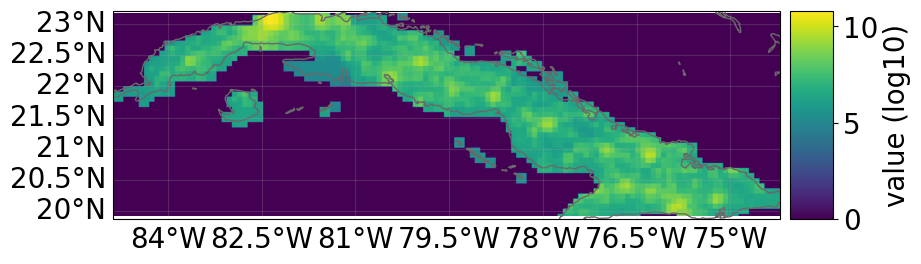

In [3]:
# not needed for impact calculations
# visualize the define exposure
exp_lp.plot_raster()
print("\n Raster properties exposures:", exp_lp.meta)

### Define the hazard 

Let us define a tropical cyclone hazard using the TropCyclone and TCTracks modules. 

In [4]:
from climada.hazard import TCTracks, TropCyclone, Centroids

# Load histrocial tropical cyclone tracks from ibtracs over the North Atlantic basin between 2010-2012
ibtracks_na = TCTracks.from_ibtracs_netcdf(
    provider="usa", basin="NA", year_range=(2010, 2012), correct_pres=True
)
print("num tracks hist:", ibtracks_na.size)

ibtracks_na.equal_timestep(
    0.5
)  # Interpolation to make the track smooth and to allow applying calc_perturbed_trajectories
# Add randomly generated tracks using the calc_perturbed_trajectories method (1 per historical track)
ibtracks_na.calc_perturbed_trajectories(nb_synth_tracks=1)
print("num tracks hist+syn:", ibtracks_na.size)

2023-01-26 11:57:25,332 - climada.hazard.tc_tracks - WARNING - `correct_pres` is deprecated. Use `estimate_missing` instead.
2023-01-26 11:57:26,701 - climada.hazard.tc_tracks - INFO - Progress: 10%
2023-01-26 11:57:26,905 - climada.hazard.tc_tracks - INFO - Progress: 20%
2023-01-26 11:57:27,075 - climada.hazard.tc_tracks - INFO - Progress: 30%
2023-01-26 11:57:27,229 - climada.hazard.tc_tracks - INFO - Progress: 40%
2023-01-26 11:57:27,390 - climada.hazard.tc_tracks - INFO - Progress: 50%
2023-01-26 11:57:27,542 - climada.hazard.tc_tracks - INFO - Progress: 60%
2023-01-26 11:57:27,713 - climada.hazard.tc_tracks - INFO - Progress: 70%
2023-01-26 11:57:27,876 - climada.hazard.tc_tracks - INFO - Progress: 80%
2023-01-26 11:57:28,032 - climada.hazard.tc_tracks - INFO - Progress: 90%
2023-01-26 11:57:28,197 - climada.hazard.tc_tracks - INFO - Progress: 100%
num tracks hist: 60
2023-01-26 11:57:28,229 - climada.hazard.tc_tracks - INFO - Interpolating 60 tracks to 0.5h time steps.
2023-01-26

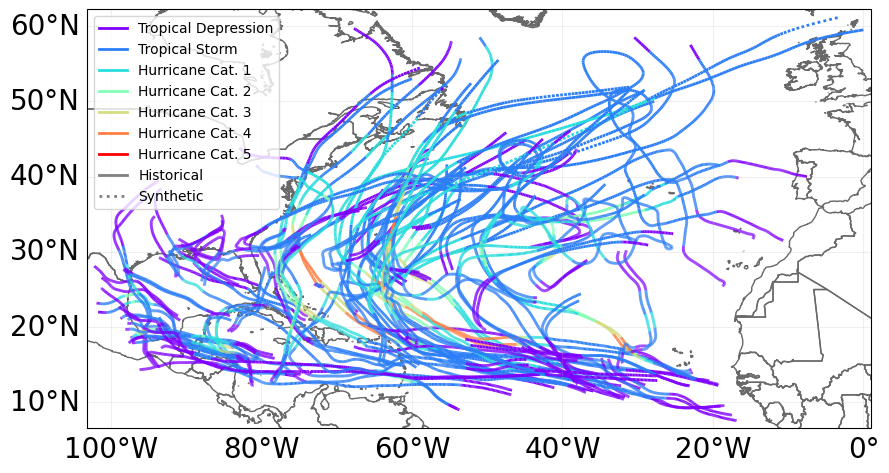

In [5]:
# not needed for calculations
# visualize tracks
ax = ibtracks_na.plot()
ax.get_legend()._loc = 2

From the tracks, we generate the hazards (the tracks are only the coordinates of the center of the cyclones, the full cyclones however affects a region around the tracks). 

First thing we define the set of centroids which are geographical points where the hazard has a defined value. In our case, we want to define windspeeds from the tracks.

Remember:
In the impact computations, for each exposure geographical point, one must assign a centroid from the hazard. By default, each exposure is assigned to the closest centroid from the hazard. But one can also define manually which centroid is assigned to which exposure point.

Examples: 
- Define the exposures from a given source (e.g., raster of asset values from LitPop). Define the hazard centroids from the exposures' geolocations (e.g. compute Tropical Cyclone windspeed at each raster point and assign centroid to each raster point).
- Define the exposures from a given source (e.g. houses position and value). Define the hazard from a given source (e.g. where lanslides occur). Use a metric to assign to each exposures point a hazard centroid (all houses in a radius of 5km around the lanslide are assigned to this centroid, if a house is within 5km of two landslides, choose the closest one). 
- Define a geographical raster. Define the exposures value on this raster. Define the hazard centroids on the geographical raster.

We shall pursue with the first case (Litpop + TropicalCyclone)

Hint: computing the wind speeds in many locations for many tc tracks is a computationally costly operation. Thus, we should define centroids only where we also have an exposure.

In [6]:
# Define the centroids from the exposures position
lat = exp_lp.gdf["latitude"].values
lon = exp_lp.gdf["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)
centrs.check()

In [7]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone.from_tracks(ibtracks_na, centroids=centrs)
tc.check()

2023-01-26 11:58:43,439 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.
2023-01-26 11:58:44,363 - climada.util.coordinates - INFO - dist_to_coast: UTM 32616 (1/3)
2023-01-26 11:58:44,606 - climada.util.coordinates - INFO - dist_to_coast: UTM 32617 (2/3)
2023-01-26 11:58:45,335 - climada.util.coordinates - INFO - dist_to_coast: UTM 32618 (3/3)
2023-01-26 11:58:45,767 - climada.hazard.trop_cyclone - INFO - Mapping 120 tracks to 1388 coastal centroids.
2023-01-26 11:58:46,030 - climada.hazard.trop_cyclone - INFO - Progress: 10%
2023-01-26 11:58:46,203 - climada.hazard.trop_cyclone - INFO - Progress: 20%
2023-01-26 11:58:46,499 - climada.hazard.trop_cyclone - INFO - Progress: 30%
2023-01-26 11:58:46,784 - climada.hazard.trop_cyclone - INFO - Progress: 40%
2023-01-26 11:58:47,231 - climada.hazard.trop_cyclone - INFO - Progress: 50%
2023-01-26 11:58:47,353 - climada.hazard.trop_cyclone - INFO - Progress: 60%
2023-01-26 11:58:47,546 - climada.hazard.t

Hint: The operation of computing the windspeed in different location is in general computationally expensive. Hence, if you have a lot of tropical cyclone tracks, you should first make sure that all your tropical cyclones actually affect your exposure (remove those that don't). Then, be careful when defining the centroids. For a large country like  China, there is no need for centroids 500km inland (no tropical cyclones gets so far).

### Impact function 

For Tropical Cyclones, some calibrated default impact functions exist. Here we will use the one from Emanuel (2011).

In [8]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()

Recall that the exposures, hazards and impact functions  must be matched in the impact calculations. Here it is simple, since there is a single impact function for all the hazards. We must simply make sure that the exposure is assigned this impact function through renaming the `impf\_` column from the hazard type of the impact function in the impact function set and set the values of the column to the id of the impact function. 

In [9]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [10]:
# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_lp.gdf["impf_" + haz_type] = haz_id
exp_lp.check()
exp_lp.gdf.head()

2023-01-26 11:58:48,792 - climada.entity.exposures.base - INFO - category_id not set.
2023-01-26 11:58:48,792 - climada.entity.exposures.base - INFO - cover not set.
2023-01-26 11:58:48,792 - climada.entity.exposures.base - INFO - deductible not set.
2023-01-26 11:58:48,792 - climada.entity.exposures.base - INFO - centr_ not set.


,value,geometry,latitude,longitude,region_id,impf_TC
0,1.077368e+05,POINT (-81.37500 21.70833),21.708333,-81.375000,192,1
1,1.671873e+06,POINT (-81.54167 21.62500),21.625000,-81.541667,192,1
2,3.421208e+06,POINT (-82.95833 21.87500),21.875000,-82.958333,192,1
3,1.546590e+07,POINT (-82.87500 21.87500),21.875000,-82.875000,192,1
4,7.168305e+07,POINT (-82.79167 21.87500),21.875000,-82.791667,192,1


### Impact computation 

We are finally ready for the impact computation. This is the simplest step. Just give the exposure, impact function and hazard to the ImpactCalc.impact() method.

Note: we did not specifically assign centroids to the exposures. Hence, the default is used - each exposure is associated with the closest centroids. Since we defined the centroids from the exposures, this is a one-to-one mapping.

Note: we did not define an `Entity`  in this impact calculations. Recall that `Entity` is a container class for __[Exposures](climada_entity_Exposures.ipynb)__, __[Impact Functions](climada_entity_ImpactFuncSet.ipynb)__, __[Discount Rates](climada_entity_DiscRates.ipynb)__ and __[Measures](climada_entity_MeasureSet.ipynb)__. Since we had only one Exposure and one Impact Function, the container would not have added any value, but for more complex projects, the Entity class is very useful.

In [11]:
# Compute impact
from climada.engine import ImpactCalc

imp = ImpactCalc(exp_lp, impf_set, tc).impact(
    save_mat=False
)  # Do not save the results geographically resolved (only aggregate values)

2023-01-26 11:58:48,877 - climada.entity.exposures.base - INFO - Matching 1388 exposures with 1388 centroids.
2023-01-26 11:58:48,877 - climada.engine.impact_calc - INFO - Calculating impact for 4164 assets (>0) and 120 events.


In [12]:
exp_lp.gdf

,value,geometry,latitude,longitude,region_id,impf_TC,centr_TC
0,1.077368e+05,POINT (-81.37500 21.70833),21.708333,-81.375000,192,1,0
1,1.671873e+06,POINT (-81.54167 21.62500),21.625000,-81.541667,192,1,1
2,3.421208e+06,POINT (-82.95833 21.87500),21.875000,-82.958333,192,1,2
3,1.546590e+07,POINT (-82.87500 21.87500),21.875000,-82.875000,192,1,3
4,7.168305e+07,POINT (-82.79167 21.87500),21.875000,-82.791667,192,1,4
...,...,...,...,...,...,...,...
1383,1.496797e+06,POINT (-78.62500 22.54167),22.541667,-78.625000,192,1,1383
1384,5.387835e+07,POINT (-78.37500 22.54167),22.541667,-78.375000,192,1,1384
1385,4.077093e+06,POINT (-78.45833 22.45833),22.458333,-78.458333,192,1,1385
1386,2.249377e+07,POINT (-78.37500 22.45833),22.458333,-78.375000,192,1,1386


For example we can now obtain the aggregated average annual impact or plot the average annual impact in each exposure location.

In [13]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 563366225.0 $


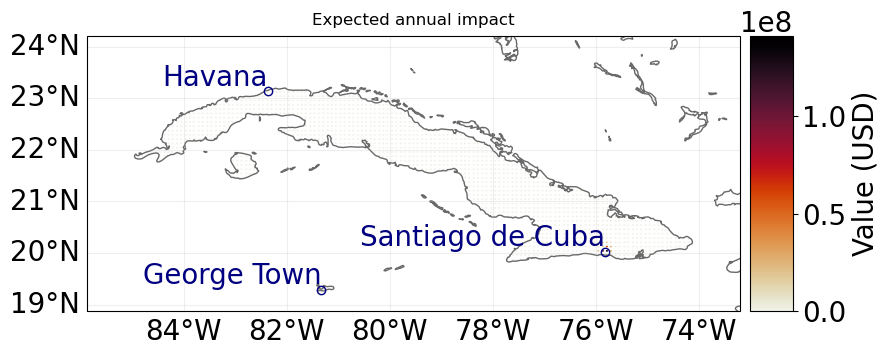

In [14]:
imp.plot_hexbin_eai_exposure(buffer=1);

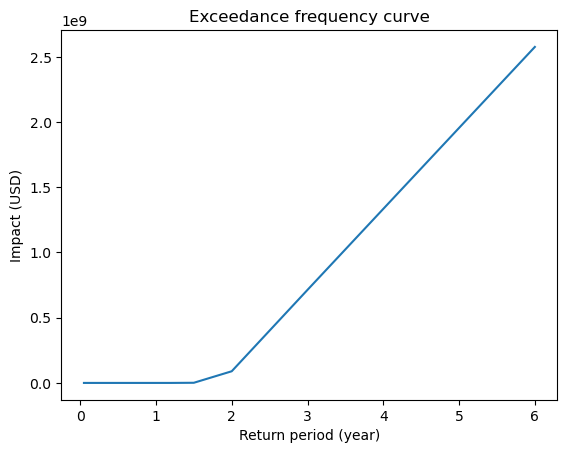

In [15]:
# Compute exceedance frequency curve
freq_curve = imp.calc_freq_curve()
freq_curve.plot();

### Impact concatenation

There can be cases in which an impact function for a given hazard type is not constant throughout the year. This is for example the case in the context of agriculture. For example, if a crop is already harvested the impact of a certain weather event can be much lower or even zero. For such situations of two or more different impact functions for the same hazard and exposure type, it can be useful to split the events into subsets and compute impacts separately. In order to then analyze the total impact, the different impact subsets can be concatenated using the `Impact.concat` method. 
This is done here for the hypothetical example using LitPop as exposure and TCs as hazard. For illustration purposes, we misuse the LitPop exposure in this case as exposure of a certain crop. We assume a constant harvest day (17 October) after which the impact function is reduced by a factor of 10.

First, we prepare the hazard subsets.

In [16]:
from datetime import datetime, date
import pandas as pd

# set a harvest date
harvest_DOY = 290  # 17 October

# loop over all events an check if they happened before or after harvest
event_ids_post_harvest = []
event_ids_pre_harvest = []
for event_id in tc.event_id:
    event_date = tc.date[np.where(tc.event_id == event_id)[0][0]]
    day_of_year = (
        event_date - date(datetime.fromordinal(event_date).year, 1, 1).toordinal() + 1
    )

    if day_of_year > harvest_DOY:
        event_ids_post_harvest.append(event_id)
    else:
        event_ids_pre_harvest.append(event_id)

tc_post_harvest = tc.select(event_id=event_ids_post_harvest)
tc_pre_harvest = tc.select(event_id=event_ids_pre_harvest)
# print('pre-harvest:', tc_pre_harvest.event_name)
# print('post-harvest:', tc_post_harvest.event_name)

Now we get two different impact functions, one valid for the exposed crop before harvest and one after harvest. Then, we compute the impacts for both phases separately.

2023-01-26 11:58:52,364 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2023-01-26 11:58:52,364 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2023-01-26 11:58:52,364 - climada.entity.exposures.base - INFO - Matching 1388 exposures with 1388 centroids.
2023-01-26 11:58:52,370 - climada.engine.impact_calc - INFO - Calculating impact for 4164 assets (>0) and 106 events.
2023-01-26 11:58:52,379 - climada.entity.exposures.base - INFO - Exposures matching centroids already found for TC
2023-01-26 11:58:52,379 - climada.entity.exposures.base - INFO - Existing centroids will be overwritten for TC
2023-01-26 11:58:52,382 - climada.entity.exposures.base - INFO - Matching 1388 exposures with 1388 centroids.
2023-01-26 11:58:52,388 - climada.engine.impact_calc - INFO - Calculating impact for 4164 assets (>0) and 14 events.


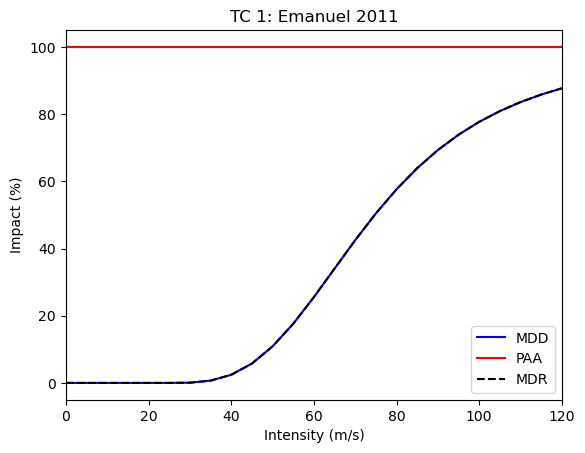

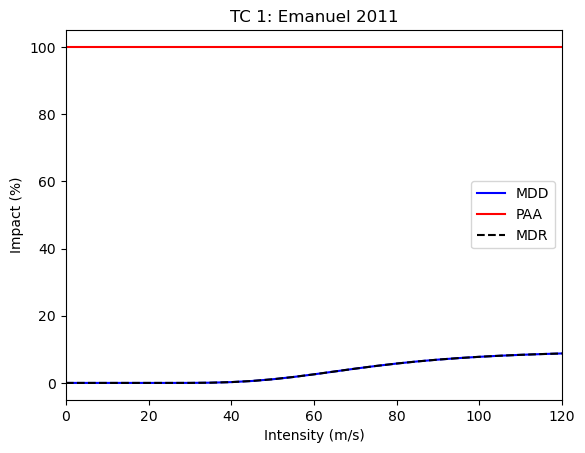

In [17]:
from climada.engine import Impact

# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()
# impact function TC after harvest is by factor 0.5 smaller
impf_tc_posth = ImpfTropCyclone.from_emanuel_usa()
impf_tc_posth.mdd = impf_tc.mdd * 0.1
# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])
impf_set_posth = ImpactFuncSet([impf_tc_posth])
impf_set.check()
impf_set_posth.check()

# plot
impf_set.plot()
impf_set_posth.plot()

# Compute impacts
imp_preh = ImpactCalc(exp_lp, impf_set, tc_pre_harvest).impact(save_mat=True)
imp_posth = ImpactCalc(exp_lp, impf_set_posth, tc_post_harvest).impact(save_mat=True)

Now, we can concatenate the impacts again and plot the results

Text(0.5, 1.0, 'Expected annual impact: Total')

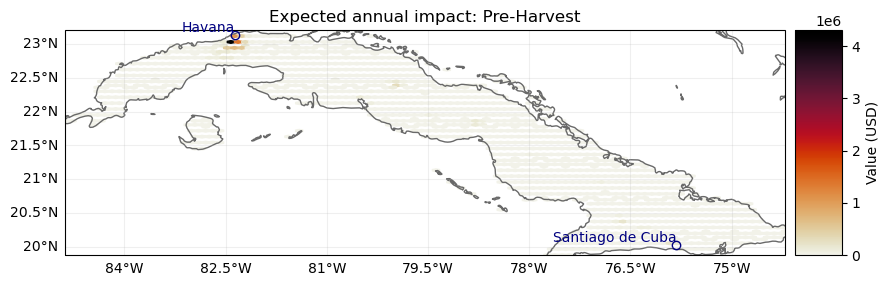

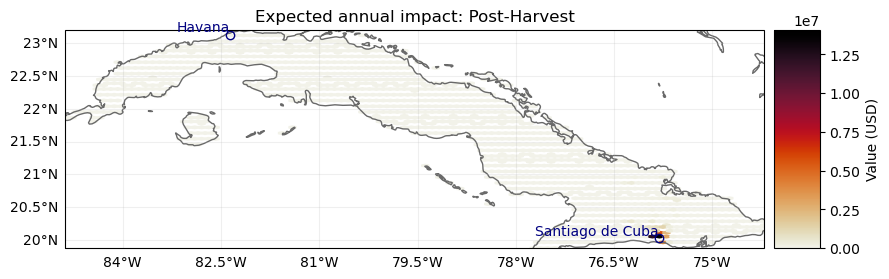

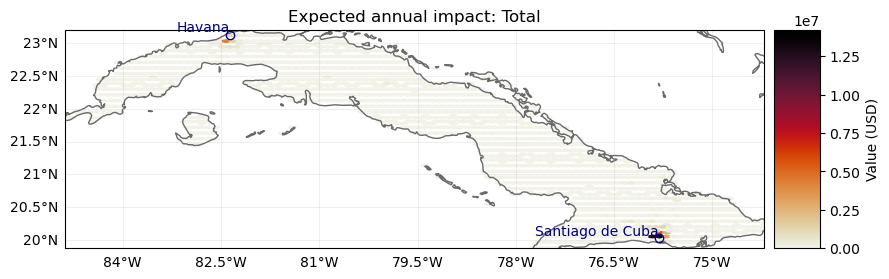

In [18]:
# Concatenate impacts again
imp_tot = Impact.concat([imp_preh, imp_posth])

# plot result
import matplotlib.pyplot as plt

ax = imp_preh.plot_hexbin_eai_exposure(gridsize=100, adapt_fontsize=False)
ax.set_title("Expected annual impact: Pre-Harvest")
ax = imp_posth.plot_hexbin_eai_exposure(gridsize=100, adapt_fontsize=False)
ax.set_title("Expected annual impact: Post-Harvest")
ax = imp_tot.plot_hexbin_eai_exposure(gridsize=100, adapt_fontsize=False)
ax.set_title("Expected annual impact: Total")

## Quick examples - points, raster, custom
<a id='part2'></a> 

### User defined point exposure and Tropical Cyclone hazard

2023-01-26 11:59:01,455 - climada.entity.exposures.base - INFO - Setting impf_ to default impact functions ids 1.
2023-01-26 11:59:01,457 - climada.entity.exposures.base - INFO - category_id not set.
2023-01-26 11:59:01,458 - climada.entity.exposures.base - INFO - cover not set.
2023-01-26 11:59:01,460 - climada.entity.exposures.base - INFO - deductible not set.
2023-01-26 11:59:01,463 - climada.entity.exposures.base - INFO - geometry not set.
2023-01-26 11:59:01,464 - climada.entity.exposures.base - INFO - region_id not set.
2023-01-26 11:59:01,466 - climada.entity.exposures.base - INFO - centr_ not set.
2023-01-26 11:59:03,801 - climada.hazard.tc_tracks - INFO - Progress: 100%
2023-01-26 11:59:03,846 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.
2023-01-26 11:59:04,466 - climada.util.coordinates - INFO - dist_to_coast: UTM 32645 (1/1)
2023-01-26 11:59:04,580 - climada.hazard.trop_cyclone - INFO - Mapping 1 tracks to 7 coastal centroids.
202

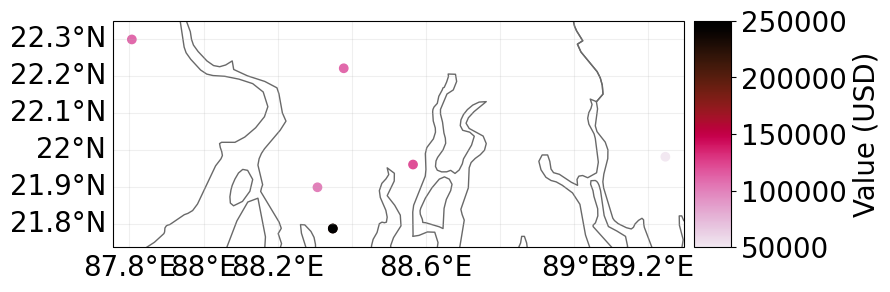

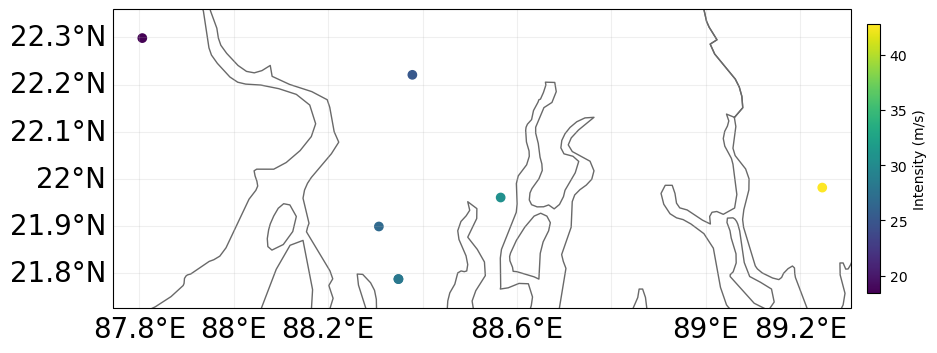

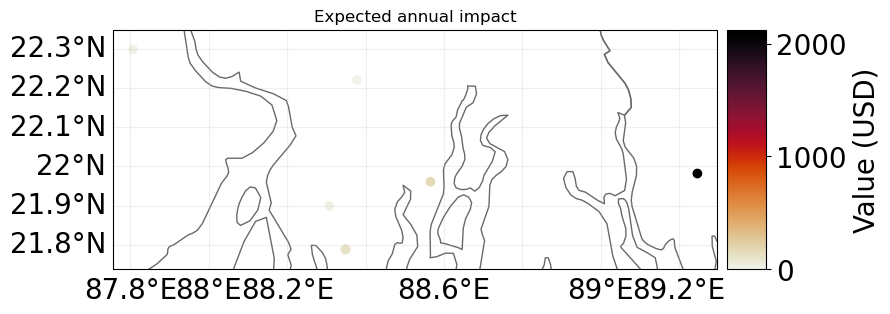

In [19]:
%matplotlib inline
# EXAMPLE: POINT EXPOSURES WITH POINT HAZARD
import numpy as np
from climada.entity import Exposures, ImpactFuncSet, IFTropCyclone
from climada.hazard import Centroids, TCTracks, TropCyclone
from climada.engine import ImpactCalc

# Set Exposures in points
exp_pnt = Exposures(crs="epsg:4326")  # set coordinate system
exp_pnt.gdf["latitude"] = np.array(
    [21.899326, 21.960728, 22.220574, 22.298390, 21.787977, 21.787977, 21.981732]
)
exp_pnt.gdf["longitude"] = np.array(
    [88.307422, 88.565362, 88.378337, 87.806356, 88.348835, 88.348835, 89.246521]
)
exp_pnt.gdf["value"] = np.array([1.0e5, 1.2e5, 1.1e5, 1.1e5, 2.0e5, 2.5e5, 0.5e5])
exp_pnt.check()
exp_pnt.plot_scatter(buffer=0.05)

# Set Hazard in Exposures points
# set centroids from exposures coordinates
centr_pnt = Centroids.from_lat_lon(exp_pnt.latitude, exp_pnt.longitude, exp_pnt.crs)
# compute Hazard in that centroids
tr_pnt = TCTracks.from_ibtracs_netcdf(storm_id="2007314N10093")
tc_pnt = TropCyclone.from_tracks(tr_pnt, centroids=centr_pnt)
tc_pnt.check()
ax_pnt = tc_pnt.centroids.plot(
    c=np.array(tc_pnt.intensity[0, :].todense()).squeeze()
)  # plot intensity per point
ax_pnt.get_figure().colorbar(
    ax_pnt.collections[0], fraction=0.0175, pad=0.02
).set_label(
    "Intensity (m/s)"
)  # add colorbar

# Set impact function
impf_tc = ImpfTropCyclone.from_emanuel_usa()
impf_pnt = ImpactFuncSet([impf_tc])
impf_pnt.check()

# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_lp.gdf["impf_" + haz_type] = haz_id
exp_lp.gdf.head()

# Compute Impact
imp_pnt = ImpactCalc(exp_pnt, impf_pnt, tc_pnt).impact()
# nearest neighbor of exposures to centroids gives identity
print(
    "Nearest neighbor hazard.centroids indexes for each exposure:",
    exp_pnt.gdf["centr_TC"].values,
)
imp_pnt.plot_scatter_eai_exposure(ignore_zero=False, buffer=0.05);

### Raster from file 

2023-01-26 11:59:11,285 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: VEN (862)...

2023-01-26 11:59:13,749 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-26 11:59:13,751 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-01-26 11:59:13,783 - climada.entity.exposures.litpop.litpop - INFO - No data point on destination grid within polygon.
2023-01-26 11:59:13,785 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-26 11:59:13,787 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-01-26 11:59:13,850 - climada.entity.exposures.litpop.gpw_population - WARNING - Reference year: 2018. Using nearest available year for GPW data: 2020
2023-01-26 11:59:13,852 - climada.entity.exposures.litpop.gpw_population - INFO - GPW 

2023-01-26 11:59:15,265 - climada.entity.exposures.litpop.gpw_population - INFO - GPW Version v4.11
2023-01-26 11:59:15,289 - climada.entity.exposures.litpop.litpop - INFO - No data point on destination grid within polygon.
2023-01-26 11:59:15,833 - climada.util.finance - INFO - GDP VEN 2014: 4.824e+11.
2023-01-26 11:59:15,909 - climada.util.finance - INFO - Income group VEN 2018: 3.
2023-01-26 11:59:15,933 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-01-26 11:59:15,934 - climada.entity.exposures.base - INFO - category_id not set.
2023-01-26 11:59:15,936 - climada.entity.exposures.base - INFO - cover not set.
2023-01-26 11:59:15,937 - climada.entity.exposures.base - INFO - deductible not set.
2023-01-26 11:59:15,939 - climada.entity.exposures.base - INFO - centr_ not set.
2023-01-26 11:59:15,949 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-01-26 11:59:15,951 - climada.entity.exposures.base - INFO - category_id not set.
2023-01

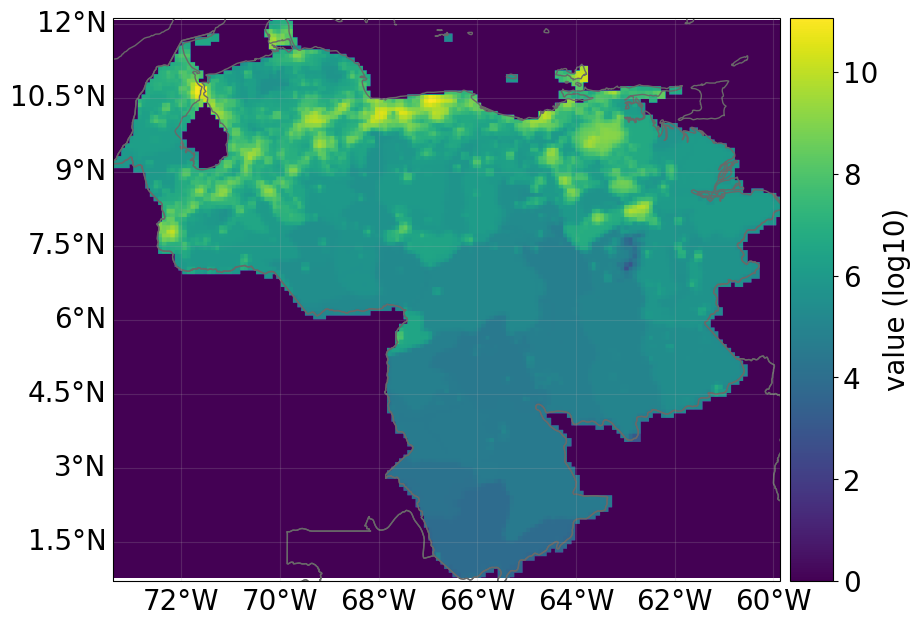

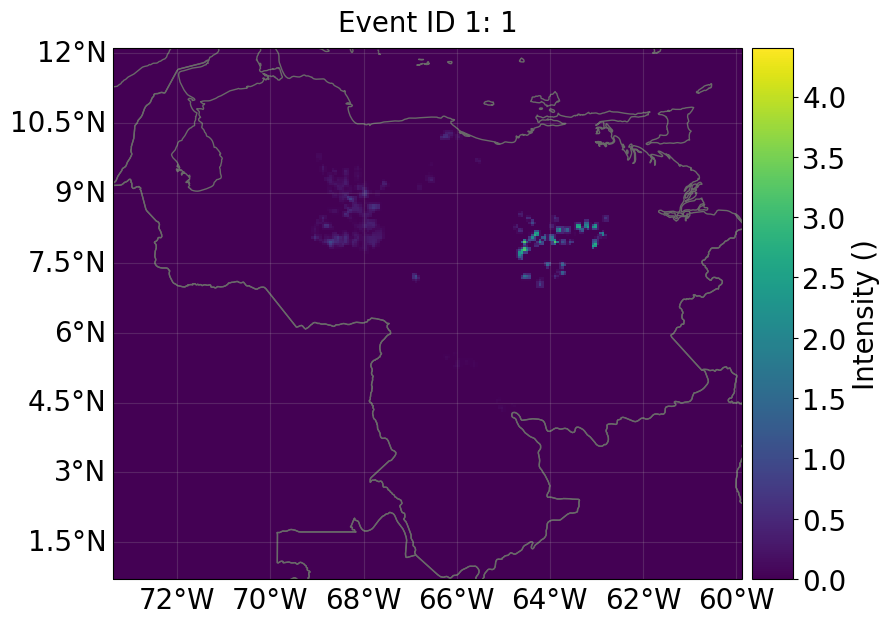

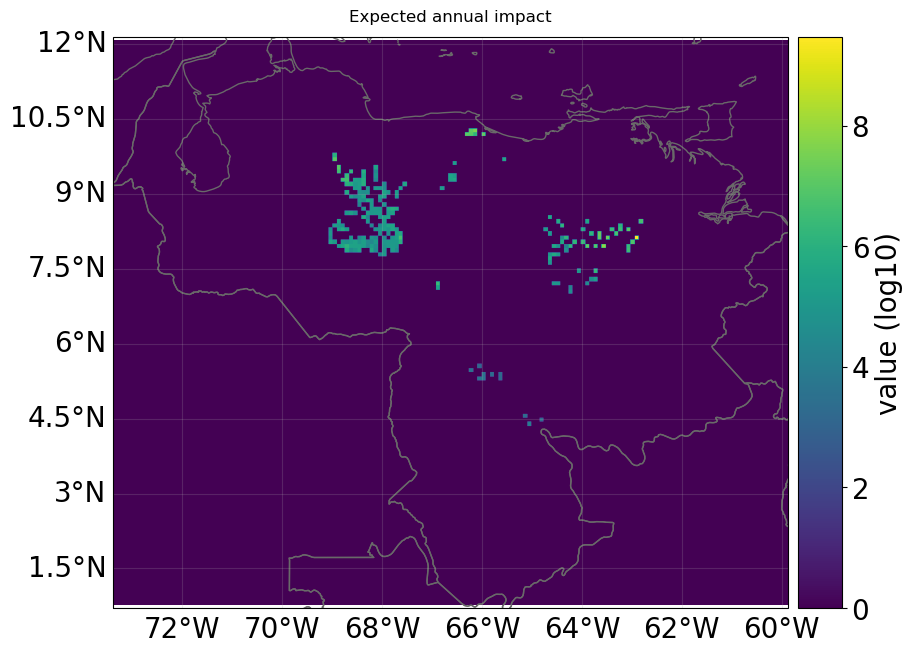

In [20]:
# EXAMPLE: RASTER EXPOSURES WITH RASTER HAZARD
from rasterio.warp import Resampling
from climada.entity import LitPop, ImpactFuncSet, ImpactFunc
from climada.hazard import Hazard
from climada.engine import Impact
from climada.util.constants import HAZ_DEMO_FL

# Exposures belonging to a raster (the raser information is contained in the meta attribute)
exp_ras = LitPop.from_countries(
    countries=["VEN"], res_arcsec=300, fin_mode="income_group"
)
exp_ras.gdf.reset_index()
exp_ras.check()
exp_ras.plot_raster()
print("\n Raster properties exposures:", exp_ras.meta)

# Initialize hazard object with haz_type = 'FL' (for Flood)
hazard_type = "FL"
# Load a previously generated (either with CLIMADA or other means) hazard
# from file (HAZ_DEMO_FL) and resample the hazard raster to the exposures' ones
# Hint: check how other resampling methods affect to final impact
haz_ras = Hazard.from_raster(
    [HAZ_DEMO_FL],
    haz_type=hazard_type,
    dst_crs=exp_ras.meta["crs"],
    transform=exp_ras.meta["transform"],
    width=exp_ras.meta["width"],
    height=exp_ras.meta["height"],
    resampling=Resampling.nearest,
)
haz_ras.intensity[haz_ras.intensity == -9999] = 0  # correct no data values
haz_ras.check()
haz_ras.plot_intensity(1)
print("Raster properties centroids:", haz_ras.centroids.meta)

# Set dummy impact function
intensity = np.linspace(0, 10, 100)
mdd = np.linspace(0, 10, 100)
paa = np.ones(intensity.size)
impf_dum = ImpactFunc(hazard_type, haz_id, intensity, mdd, paa, "m", "dummy")
# Add the impact function to the impact function set
impf_ras = ImpactFuncSet([impf_dum])
impf_ras.check()

# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + hazard_type}, inplace=True)
exp_lp.gdf["impf_" + haz_type] = haz_id
exp_lp.gdf.head()

# Compute impact
imp_ras = ImpactCalc(exp_ras, impf_ras, haz_ras).impact(save_mat=False)
# nearest neighbor of exposures to centroids is not identity because litpop does not contain data outside the country polygon
print(
    "\n Nearest neighbor hazard.centroids indexes for each exposure:",
    exp_ras.gdf["centr_FL"].values,
)
imp_ras.plot_raster_eai_exposure();

## Visualization
<a id='part3'></a> 

### Making plots 

The expected annual impact per exposure can be visualized through different methods: `plot_hexbin_eai_exposure()`, `plot_scatter_eai_exposur()`, `plot_raster_eai_exposure()` and `plot_basemap_eai_exposure()` (similarly as with  `Exposures`).

2023-01-26 11:59:40,355 - climada.util.coordinates - INFO - Setting geometry points.
2023-01-26 11:59:40,364 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-01-26 11:59:43,294 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


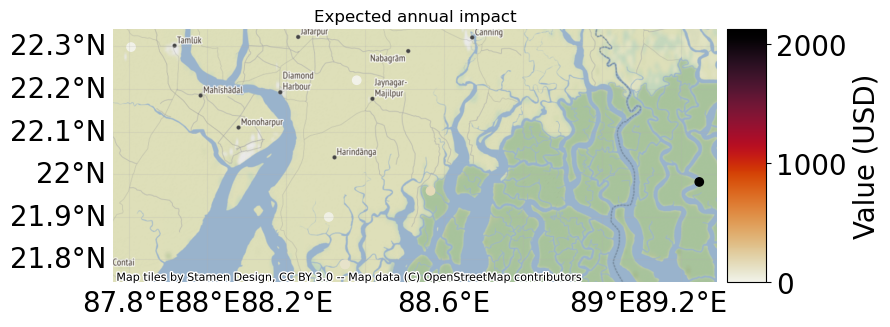

In [21]:
imp_pnt.plot_basemap_eai_exposure(buffer=5000);

### Making videos

Given a fixed exposure and impact functions, a sequence of hazards can be visualized hitting the exposures.

In [22]:
# exposure
from climada.entity import add_sea
from climada_petals.entity import BlackMarble

exp_video = BlackMarble()
exp_video.set_countries(["Cuba"], 2016, res_km=2.5)
exp_video.check()

# impact function
impf_def = ImpfTropCyclone.from_emanuel_usa()
impfs_video = ImpactFuncSet([impf_def])
impfs_video.check()

# compute sequence of hazards using TropCyclone video_intensity method
exp_sea = add_sea(exp_video, (100, 5))
centr_video = Centroids.from_lat_lon(exp_sea.latitude, exp_sea.longitude)
centr_video.check()

track_name = "2017242N16333"
tr_irma = TCTracks.from_ibtracs_netcdf(provider="usa", storm_id=track_name)  # IRMA 2017

tc_video = TropCyclone()
tc_list, _ = tc_video.video_intensity(
    track_name, tr_irma, centr_video
)  # empty file name to not to write the video

# generate video of impacts
file_name = "./results/irma_imp_fl.gif"
imp_video = Impact()
imp_list = imp_video.video_direct_impact(exp_video, impfs_video, tc_list, file_name)

2023-01-26 11:59:44,414 - climada.util.finance - INFO - GDP CUB 2016: 9.137e+10.
2023-01-26 11:59:44,483 - climada.util.finance - INFO - Income group CUB 2016: 3.
2023-01-26 11:59:44,483 - climada_petals.entity.exposures.black_marble - INFO - Nightlights from NASA's earth observatory for year 2016.
2023-01-26 11:59:48,126 - climada_petals.entity.exposures.black_marble - INFO - Processing country Cuba.
2023-01-26 11:59:48,987 - climada_petals.entity.exposures.black_marble - INFO - Generating resolution of approx 2.5 km.
2023-01-26 11:59:49,129 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-01-26 11:59:49,137 - climada.entity.exposures.base - INFO - category_id not set.
2023-01-26 11:59:49,137 - climada.entity.exposures.base - INFO - cover not set.
2023-01-26 11:59:49,137 - climada.entity.exposures.base - INFO - deductible not set.
2023-01-26 11:59:49,137 - climada.entity.exposures.base - INFO - geometry not set.
2023-01-26 11:59:49,137 - climada.entity.exposu

2023-01-26 12:00:44,084 - climada.engine.impact_calc - INFO - Calculating impact for 43962 assets (>0) and 1 events.
2023-01-26 12:00:44,105 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-26 12:00:44,105 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2023-01-26 12:00:44,105 - climada.engine.impact_calc - INFO - Calculating impact for 43962 assets (>0) and 1 events.
2023-01-26 12:00:44,121 - climada.engine.impact - WARNING - The use of Impact().calc() is deprecated. Use ImpactCalc().impact() instead.
2023-01-26 12:00:44,121 - climada.entity.exposures.base - INFO - No specific impact function column found for hazard TC. Using the anonymous 'impf_' column.
2023-01-26 12:00:44,136 - climada.engine.impact_calc - INFO - Calculating impact for 43962 assets (>0) and 1 events.
2023-01-26 12:00:44,136 - climada.engine.impact - WARNING - T

22it [09:44, 26.57s/it]                                                                                                
